## Figure08

## Plot the diagram below

In [3]:
## Masked spatial plots
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.patches import PathPatch
import cmaps
from shapely.geometry import box
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib.ticker as mticker

#################### Calculate metric value ####################

def abs_mean(arr):
    """
    Calculates the absolute mean of a given Numpy Array
    """
    arr = arr.flatten()
    arr = np.nanmean(abs(arr))
    return arr

def mean(arr):
    """
    Calculates the absolute mean of a given Numpy Array
    """
    arr = arr.flatten()
    arr = np.nanmean(arr)
    return arr

def create_axes(nrows, ncols, figsize=(13,13), hspace=None, wspace=None):
    
    # Create figure and axis objects
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows, ncols, figure=fig, hspace=hspace) #  , wspace=wspace hspace=0.5, wspace=0

    # Create subplots with specific projection using GridSpec
    axes = []
    for i in range(nrows):
        for j in range(ncols):
            ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
            axes.append(ax)
    # fig.tight_layout()

    # fig.tight_layout(pad=0) 
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    return fig, axes

def create_shared_axes(nrows, ncols, figsize=(13, 13), hspace=None, wspace=None):
    # Create figure and GridSpec
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows, ncols, figure=fig, hspace=hspace, wspace=wspace)

    axes = []
    first_ax = None

    for i in range(nrows):
        row_axes = []
        for j in range(ncols):
            ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
            if first_ax is None:
                first_ax = ax
            else:
                # Share x and y axis with the first axis
                ax.sharex(first_ax)
                ax.sharey(first_ax)
            axes.append(ax)

    return fig, axes

def get_lon_lat(ds, data_var):
    """
    Extract longitude and latitude values from 
    xarray array and variable name
    """
    
    data_coords = ds[data_var].coords
    lon_var, lat_var = None, None

    for coord_name, coord_var in data_coords.items():
        if 'longitude' in coord_var.standard_name or 'lon' in coord_var.standard_name:
            lon_var = coord_var
        elif 'latitude' in coord_var.standard_name or 'lat' in coord_var.standard_name:
            lat_var = coord_var

    return lon_var, lat_var

def filter_df(df, column, string):
    """ Select and merge rows from the dataframe where the specified string is present in the specified column""" 
    df.columns = df.columns.str.strip()
    filtered_df = df[df[column].str.contains(string, na=False)]
    return filtered_df

def df_to_dict(df, key_col, value_cols):
    """
    Convert multiple columns of a DataFrame into a dictionary with lists of values.
    """
    return df.set_index(key_col)[value_cols].T.to_dict('list')

def mask_array(dataarray, maskarray):
    """Mask an xarray dataarray"""
    if isinstance(maskarray, xr.DataArray):
        maskarray = maskarray.values
    if dataarray.shape[1:2] != maskarray.shape[1:2]:
        raise ValueError("dataarray and maskarray must have the same shape")
    return dataarray*maskarray

def my_custom_subplot(ax, ds, lonlat, cmap, vmin, vmax, 
                      title=None, ylabel=None, 
                      text=None, text_loc=None, 
                      overlay_pval=False, pval_data=None, 
                     ):
    
    # Plot data ds1 with inverted y-axis
    im = ax.imshow(ds, 
                   cmap=cmap, 
                   alpha=1.0, 
                   vmin=vmin, 
                   vmax=vmax,
                   extent=[lonlat[0].data.min(), 
                           lonlat[0].data.max(),
                           lonlat[1].data.max(),
                           lonlat[1].data.min()], 
                   origin='upper', 
                   transform=ccrs.PlateCarree()
                  )
    # ---------------
    # Add coastlines
    # ---------------
    ax.coastlines(resolution='50m')
    ax.invert_yaxis()
    
    # --------------------
    # Add India shapefile
    # --------------------
    shapefile_path = "/home/midhunm/AI4KLIM/EXPMNTS/P07A_DeepDown_Comparison/ANALYSE/PLTDATA/SHAPEFILES/India.shp"         
    shapefile_df = gpd.read_file(shapefile_path)
    countries = shapefile_df['geometry']
    ax.add_geometries(countries, ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=2)

    # -----------------------
    # Overlay pvalue hatches 
    # -----------------------
    if overlay_pval:

        if pval_data is None:
            raise ValueError('You have asked to plot pval stipples, but no data passed.')
        else:
            significance_threshold = 0.01
            significant_mask = pval_data <= significance_threshold
        

    
        # Overlay hatched polygons for significant correlations
        bbox = box(lonlat[0].data.min(), lonlat[1].data.min(), lonlat[0].data.max(), lonlat[1].data.max())
        for geom in countries:
            if bbox.intersects(geom):
                masked_geom = geom.intersection(bbox)
                if masked_geom.is_empty:
                    continue   
                if significant_mask.sel(longitude=slice(masked_geom.bounds[0], masked_geom.bounds[2]),
                                         latitude=slice(masked_geom.bounds[1], masked_geom.bounds[3])).any():
                    ax.add_geometries([masked_geom], 
                                      ccrs.PlateCarree(), 
                                      facecolor='none', 
                                      edgecolor='k', 
                                      hatch='.', 
                                      linewidth=1)
                    continue
    
    # -------------------------
    # Add text inside the plot
    # -------------------------
    if text is not None:
        ax.text(text_loc[0], text_loc[1], 
                text, 
                transform=ax.transAxes, ha='center', va='center', 
                fontsize=28, fontweight='bold', 
                color='blue', backgroundcolor=None, bbox=None)

    # ------------------------------
    # Additional plot customization
    # ------------------------------
    ax.set_title(title, loc='center', fontsize=24, fontfamily='serif', fontweight='semibold')
    ax.set_ylabel(ylabel, loc='center', fontsize=22, fontweight='semibold')
    # ax.set_xticks(np.arange(70, 100, 5), crs=ccrs.PlateCarree())
    # ax.set_yticks(np.arange(10, 40, 5), crs=ccrs.PlateCarree())
    # lon_formatter = LongitudeFormatter(zero_direction_label=False)
    # lat_formatter = LatitudeFormatter()
    # ax.xaxis.set_major_formatter(lon_formatter)
    # ax.yaxis.set_major_formatter(lat_formatter)
    # ax.tick_params(axis="both", labelsize=20)

    # Add longitude and latitude ticks and format them
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(90, 100.5, 5))#(70, 101, 5))
    gl.ylocator = mticker.FixedLocator(np.arange(19, 31, 5))#(10, 41, 5))
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    # ax.set_axis_off()
    
    return im

## Mean of Bias

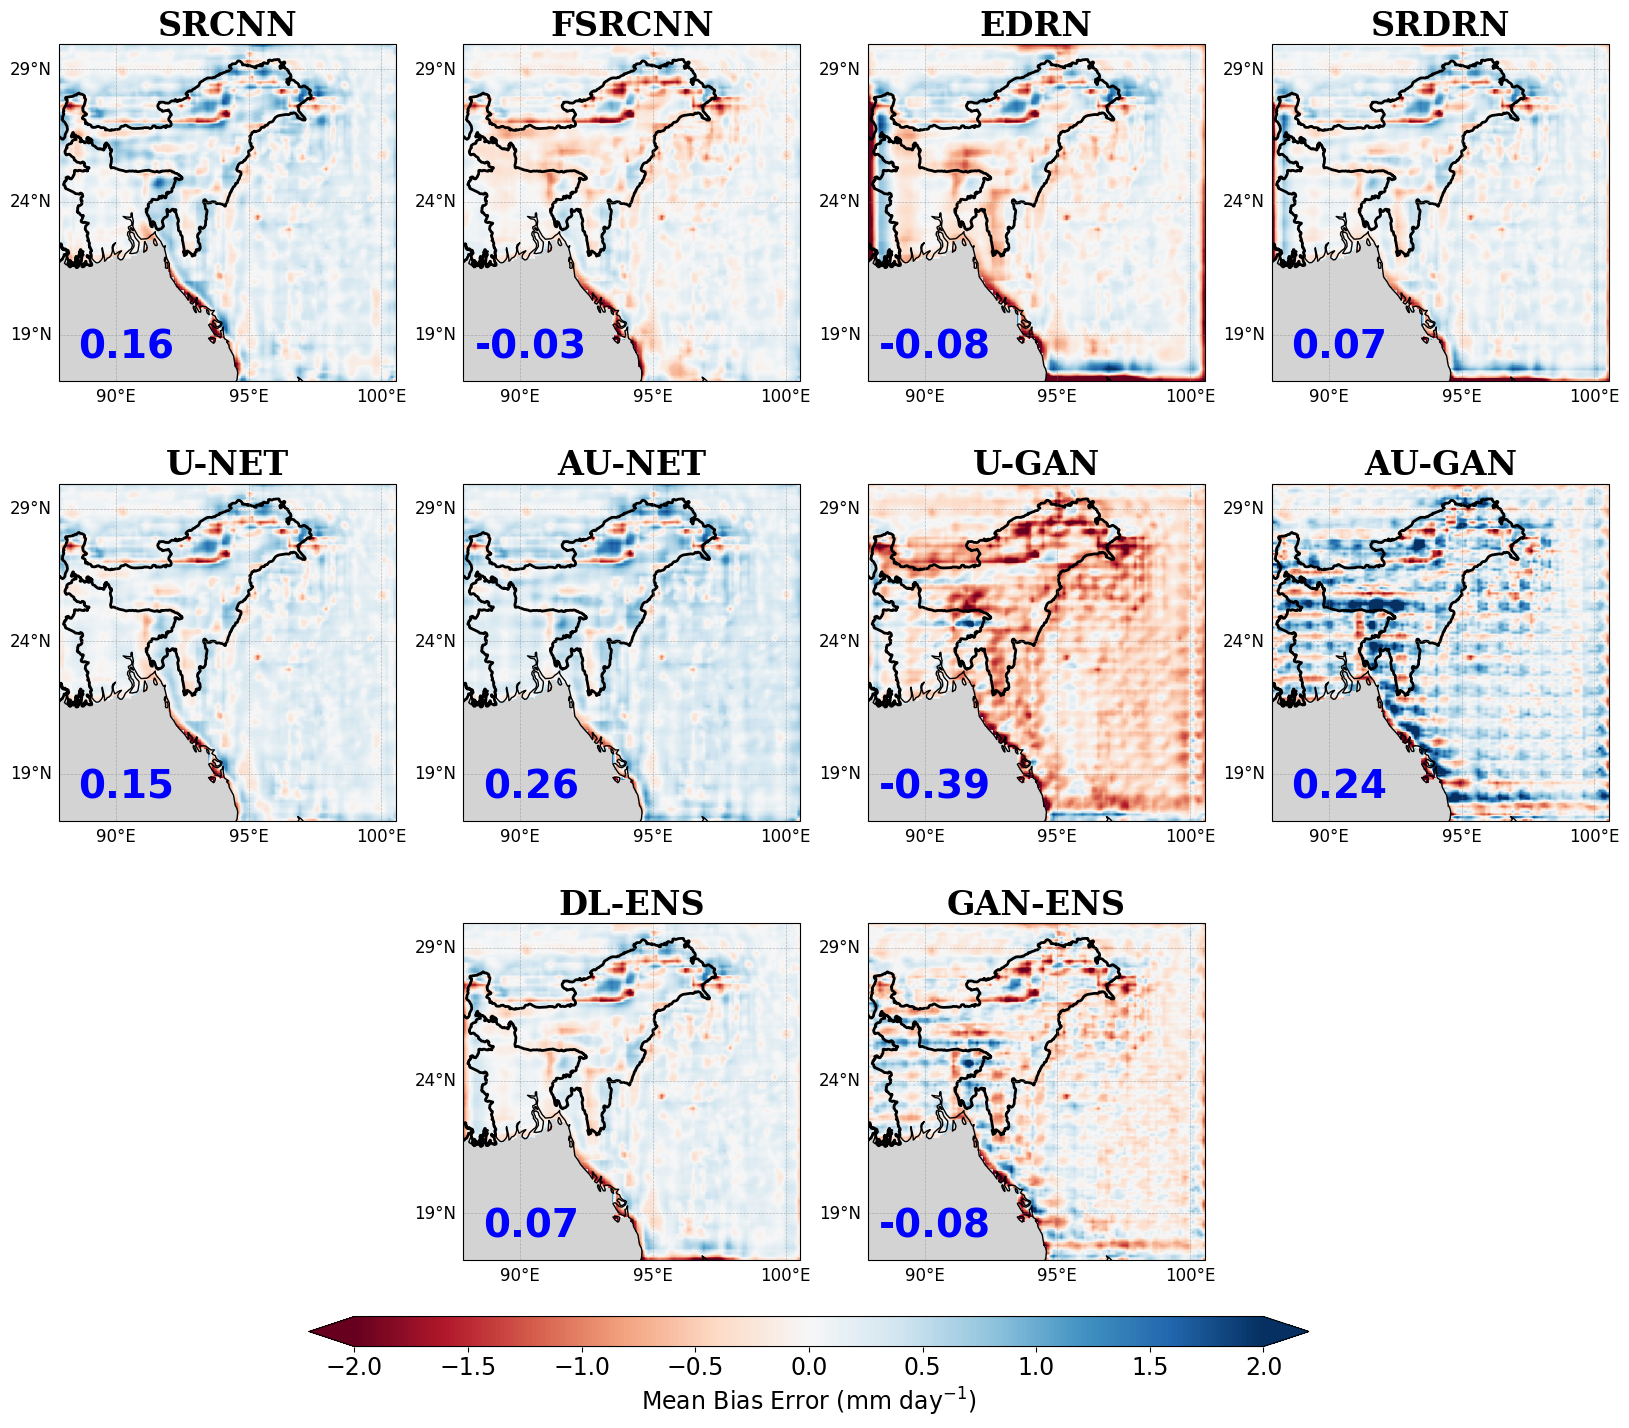

In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

#-----------------------------------------------------------------------
######################## Main run control below ########################
#-----------------------------------------------------------------------

# Assuming create_axes and my_custom_subplot are defined elsewhere in your code

# Create axes for subplots and set lonlat limits
fig, axes = create_axes(nrows=3, ncols=4, figsize=(20, 15), hspace=None, wspace=None)
# Turn off the unused axes
axes[8].set_axis_off()
axes[11].set_axis_off()


# indices to fill: first two rows (0–7) and the two center slots of row 2 (9,10)
fill_ix = [0,1,2,3,4,5,6,7,9,10]

lon_l, lat_l = (88, 100.5, 3), (18, 31, 3)

# Load datafiles
DPATH = "/home/midhunm/AI4KLIM/EXPMNTS/P02A_DeepDown_Generalization/ANALYSE/PLTDATA/FM08_Spatial_Metrics"

cbar_label = r'Mean Bias Error (mm day$^{-1}$)'

d = xr.open_dataset(f'{DPATH}/EVAL_METRICS_SPATIAL_E01_C01_2001_2023.nc')
m = xr.open_dataset('/home/midhunm/AI4KLIM/EXPMNTS/P02A_DeepDown_Generalization/ANALYSE/UTILITY/MASKFILES/MASK_C01_SM.nc')

# Set colormap with NaN (bad) color as grey
cmap = plt.cm.RdBu.copy()
cmap.set_bad(color='lightgrey')

metric_id = 'MBE'
vmin, vmax, inc = -2, 2, 0.5

exp_dict =  {
    'M00': 'SRCNN',
    'M01': 'FSRCNN',
    'M02': 'EDRN',
    'M03': 'SRDRN',
    'M04': 'U-NET',
    'M05': 'AU-NET',
    'M07': 'U-GAN',
    'M08': 'AU-GAN',
    'END': 'DL-ENS',
    'ENG': 'GAN-ENS',
}

for i, (_, model_id) in zip(fill_ix, exp_dict.items()):


    exp_id = 'E01'
    my_var = f'{model_id}_{metric_id}'.replace(" ", "")
    # Apply mask to the data array (assuming mask_array handles np.nan correctly)
    ds_f = mask_array(d[my_var].squeeze(), m['mask'].squeeze())
    
    # Make sure ds_f is a masked array or contains np.nan where needed
    
    im = my_custom_subplot(
        ax=axes[i], 
        ds=ds_f,
        lonlat=get_lon_lat(d, my_var), 
        cmap=cmap, vmin=vmin, vmax=vmax,
        text=np.nanmean(ds_f.data).round(2),
        text_loc=[0.20, 0.1],
        ylabel=None,
        title=model_id,
        overlay_pval=False,
        pval_data=None,
    )

# fig.suptitle('(a)', fontsize=32, fontweight='normal', y=0.93)

#----------------------------------------------------
# Uncomment below code snippet to set horizontal cbar 
#----------------------------------------------------

fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0.25, 0.002, 0.5, 0.02])
cb = fig.colorbar(im, cax=cbar_ax, 
                  ticks=np.arange(vmin, vmax+inc, inc), 
                  orientation="horizontal", 
                  extend='both')
cb.ax.tick_params(labelsize=17)
cb.set_label(cbar_label, 
             rotation=0, 
             fontsize=17, 
             fontweight='normal') 

SAVE_DIR = '/home/midhunm/AI4KLIM/EXPMNTS/P02A_DeepDown_Generalization/ANALYSE/RESULTS'
plt.savefig(f'{SAVE_DIR}/Figure08.jpg', format='jpg', dpi=500, bbox_inches='tight', facecolor='w', edgecolor='w')
plt.show()


## Supplementary Information

In [38]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def plot_suppinfo_mbe(dom, text_loc, lon_l, lat_l):
    #-----------------------------------------------------------------------
    ######################## Main run control below ########################
    #-----------------------------------------------------------------------
    
    # Assuming create_axes and my_custom_subplot are defined elsewhere in your code
    
    # Create axes for subplots and set lonlat limits
    fig, axes = create_axes(nrows=3, ncols=4, figsize=(20, 15), hspace=None, wspace=None)
    # Turn off the unused axes
    axes[8].set_axis_off()
    axes[11].set_axis_off()
    
    
    # indices to fill: first two rows (0–7) and the two center slots of row 2 (9,10)
    fill_ix = [0,1,2,3,4,5,6,7,9,10]
    
    # lon_l, lat_l = (88, 100.5, 3), (18, 31, 3)
    
    # Load datafiles
    DPATH = "/home/midhunm/AI4KLIM/EXPMNTS/P02A_DeepDown_Generalization/ANALYSE/PLTDATA/FM08_Spatial_Metrics"
    
    cbar_label = r'Mean Bias Error (mm day$^{-1}$)'
    
    d = xr.open_dataset(f'{DPATH}/EVAL_METRICS_SPATIAL_E01_{dom}_2015_2023.nc')
    m = xr.open_dataset(f'/home/midhunm/AI4KLIM/EXPMNTS/P02A_DeepDown_Generalization/ANALYSE/UTILITY/MASKFILES/MASK_{dom}_SM.nc')
    
    # Set colormap with NaN (bad) color as grey
    cmap = plt.cm.RdBu.copy()
    cmap.set_bad(color='lightgrey')
    
    metric_id = 'MBE'
    vmin, vmax, inc = -2, 2, 0.5
    
    exp_dict =  {
        'M00': 'SRCNN',
        'M01': 'FSRCNN',
        'M02': 'EDRN',
        'M03': 'SRDRN',
        'M04': 'U-NET',
        'M05': 'AU-NET',
        'M07': 'U-GAN',
        'M08': 'AU-GAN',
        'END': 'DL-ENS',
        'ENG': 'GAN-ENS',
    }
    
    for i, (_, model_id) in zip(fill_ix, exp_dict.items()):
    
    
        exp_id = 'E01'
        my_var = f'{model_id}_{metric_id}'.replace(" ", "")
        # Apply mask to the data array (assuming mask_array handles np.nan correctly)
        ds_f = mask_array(d[my_var].squeeze(), m['mask'].squeeze())
        
        # Make sure ds_f is a masked array or contains np.nan where needed
        
        im = my_custom_subplot(
            ax=axes[i], 
            ds=ds_f,
            lonlat=get_lon_lat(d, my_var), 
            cmap=cmap, vmin=vmin, vmax=vmax,
            text=np.nanmean(ds_f.data).round(2),
            text_loc=text_loc,
            ylabel=None,
            title=model_id,
            overlay_pval=False,
            pval_data=None,
        )
    
    # fig.suptitle('(a)', fontsize=32, fontweight='normal', y=0.93)
    
    #----------------------------------------------------
    # Uncomment below code snippet to set horizontal cbar 
    #----------------------------------------------------
    
    fig.subplots_adjust(bottom=0.05)
    cbar_ax = fig.add_axes([0.25, 0.002, 0.5, 0.02])
    cb = fig.colorbar(im, cax=cbar_ax, 
                      ticks=np.arange(vmin, vmax+inc, inc), 
                      orientation="horizontal", 
                      extend='both')
    cb.ax.tick_params(labelsize=17)
    cb.set_label(cbar_label, 
                 rotation=0, 
                 fontsize=17, 
                 fontweight='normal') 
    
    SAVE_DIR = '/home/midhunm/AI4KLIM/EXPMNTS/P02A_DeepDown_Generalization/ANALYSE/RESULTS/SUPPINFO'
    plt.savefig(f'{SAVE_DIR}/Figure08_{metric_id}_{dom}.jpg', format='jpg', dpi=500, bbox_inches='tight', facecolor='w', edgecolor='w')
    plt.show()


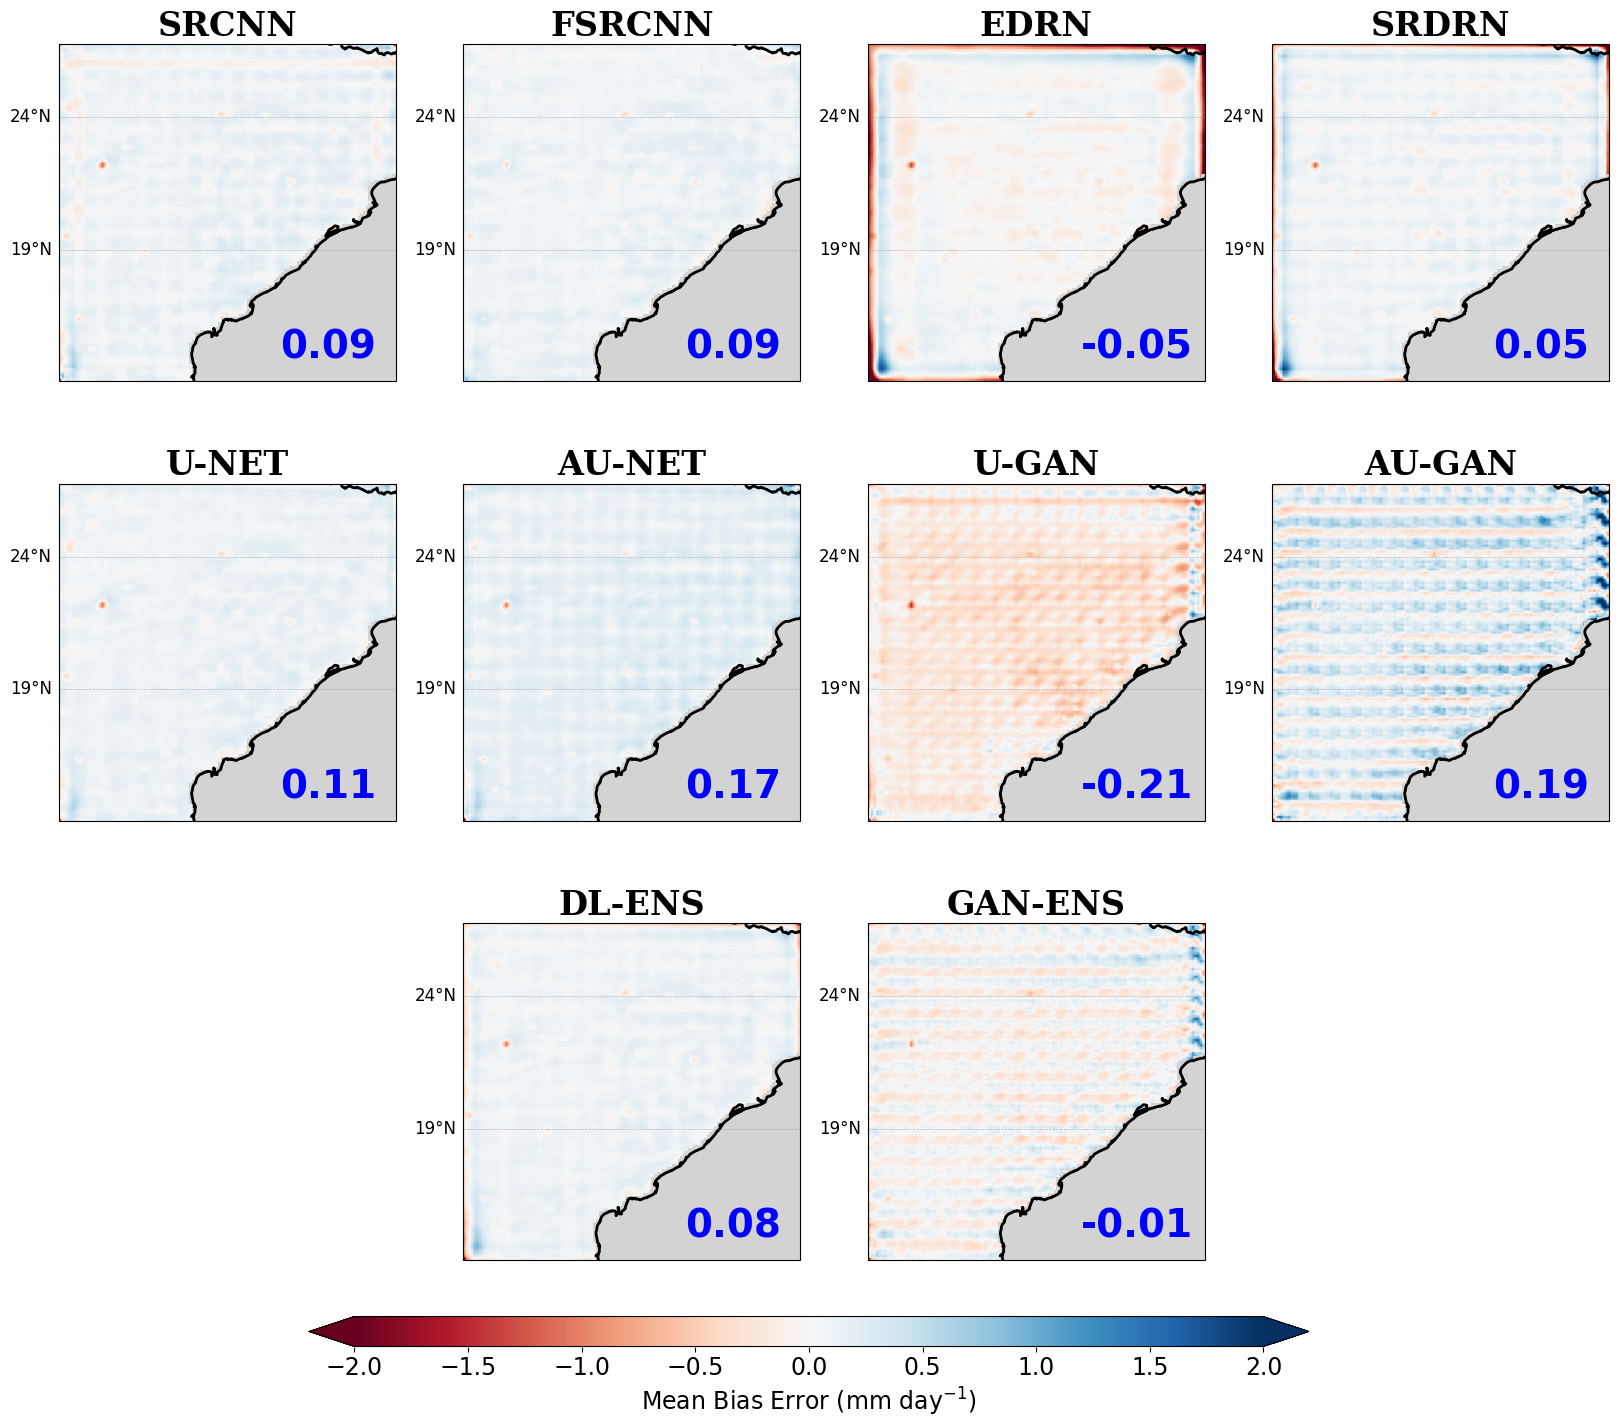

In [43]:
lon_l, lat_l = (75, 88, 3), (14, 27, 3)
text_loc = (0.80, 0.1)
plot_suppinfo_mbe('B01', text_loc, lon_l, lat_l)

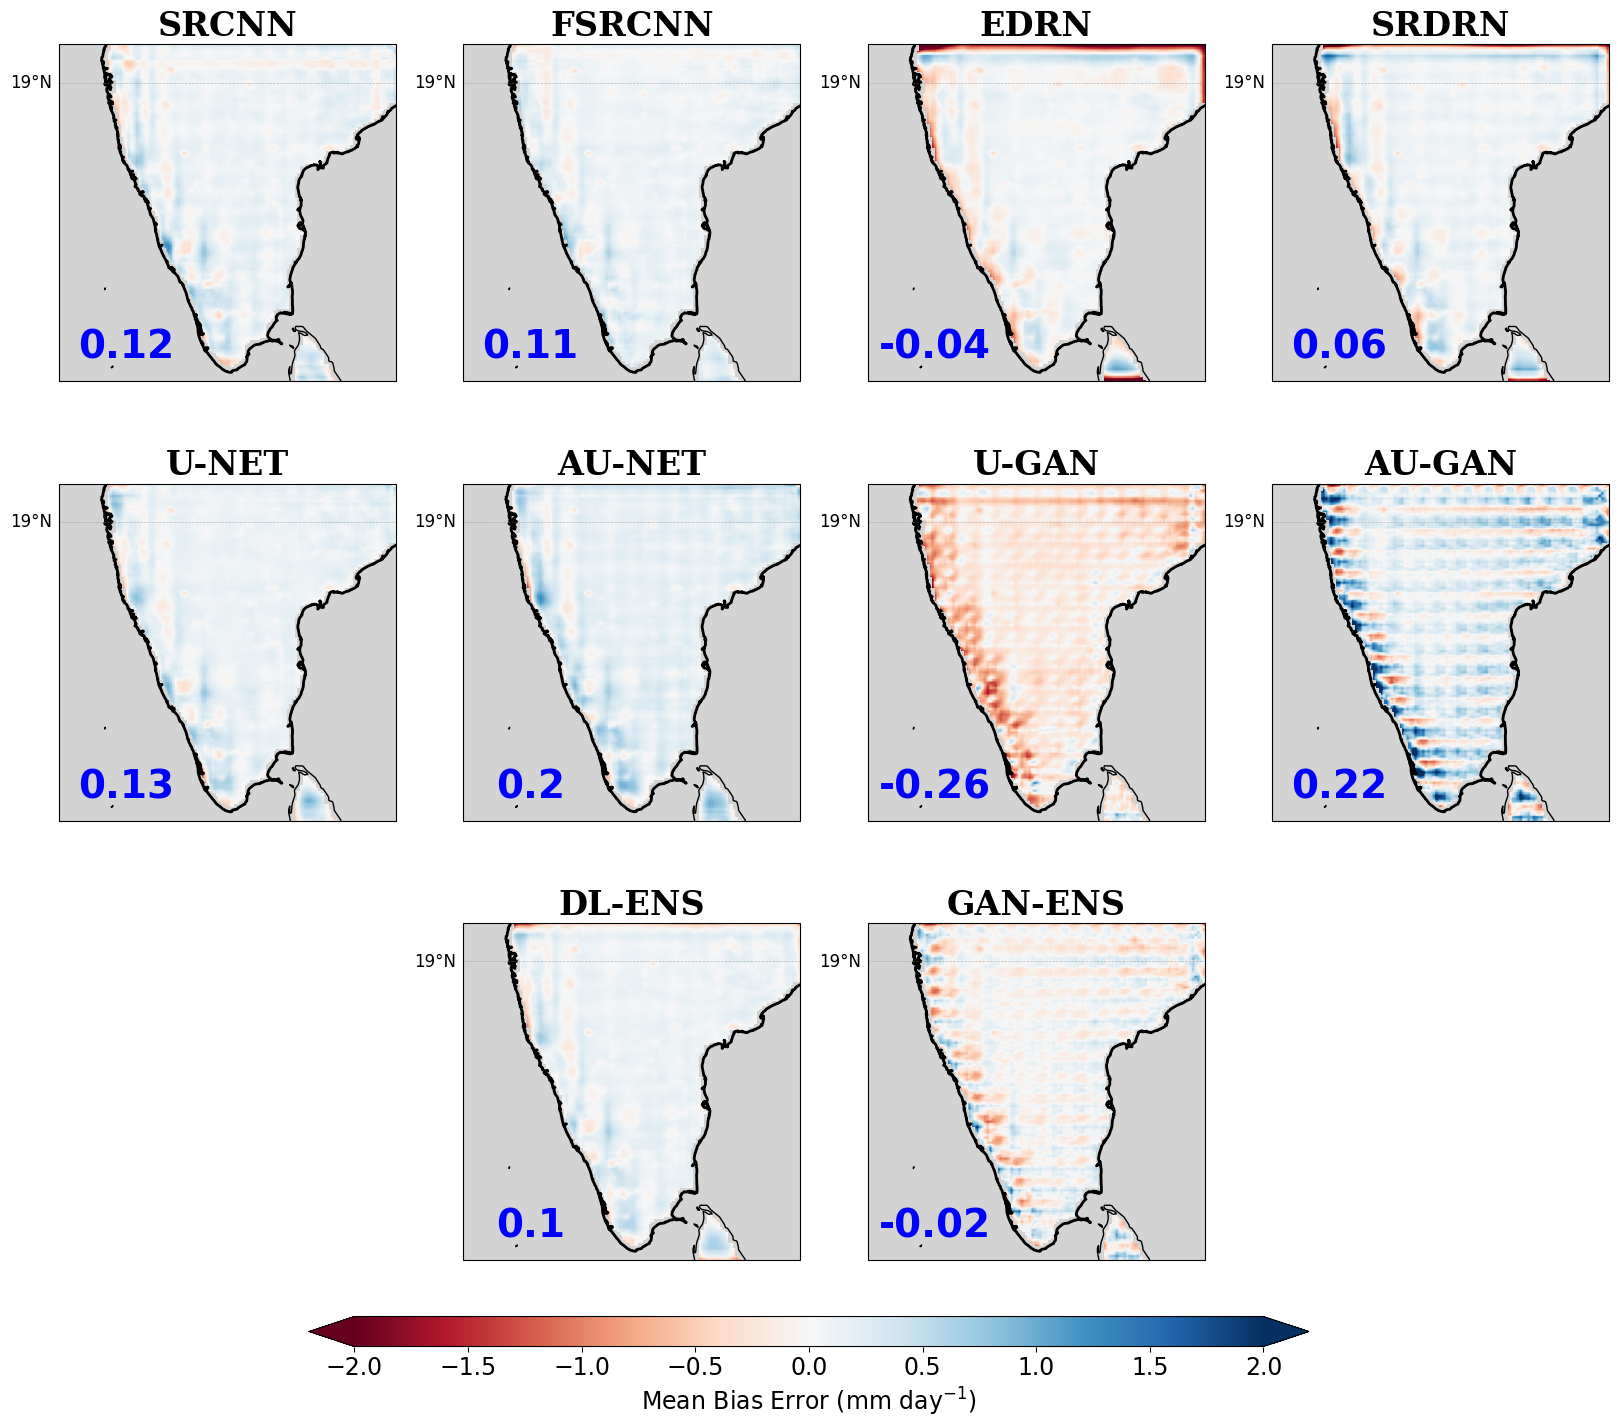

In [42]:
lon_l, lat_l = (71, 84, 3), (8, 21, 3)
text_loc = (0.20, 0.1)
plot_suppinfo_mbe('B02', text_loc, lon_l, lat_l)

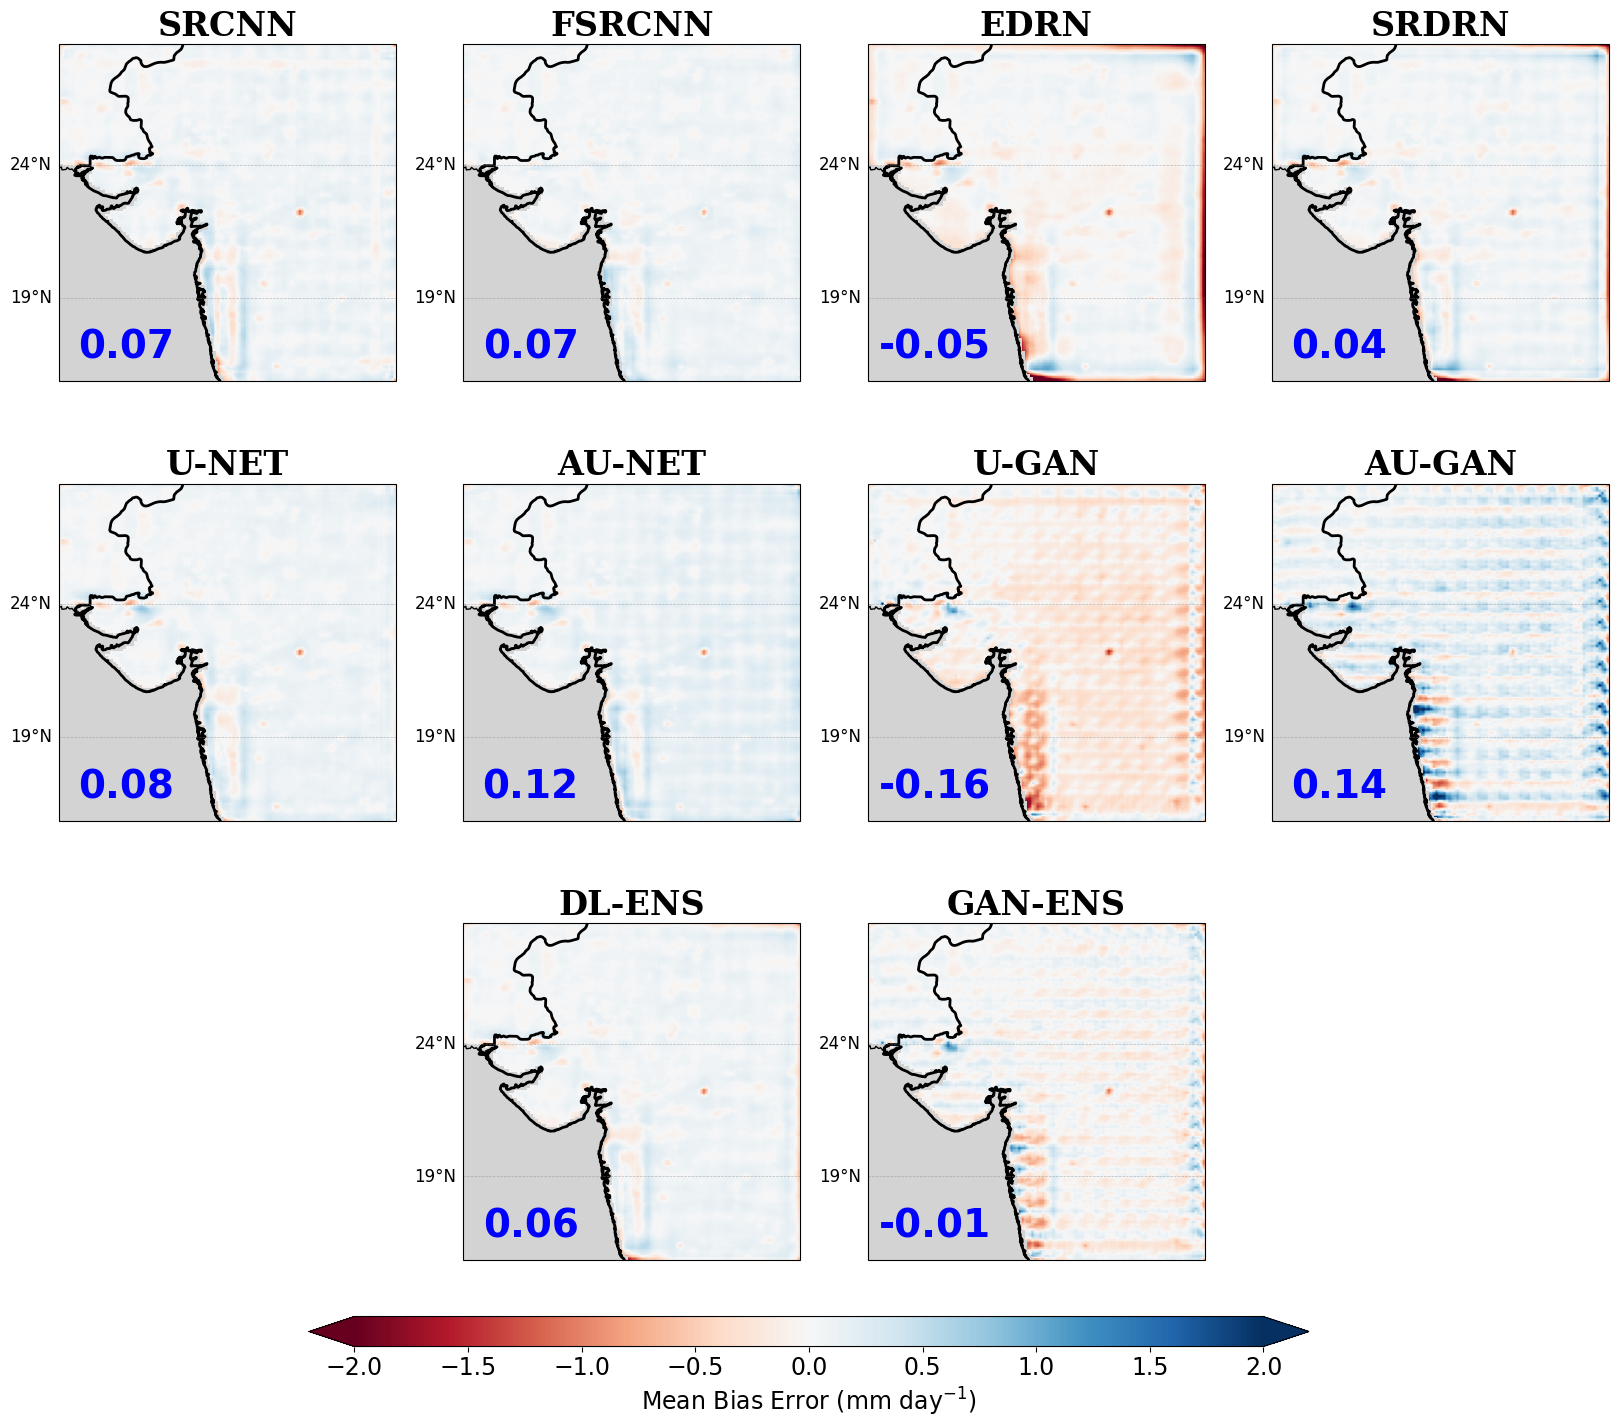

In [41]:
lon_l, lat_l = (68, 81, 3), (16, 29, 3)
text_loc = (0.20, 0.1)
plot_suppinfo_mbe('B03', text_loc, lon_l, lat_l)